# Modelo predictivo con regresión logística - Caso TITANIC

Se trabajará con el dataset de datos del titanic para generar modelos de Machine Learning que permitan predecir si un pasajero sobrevive o no. El dataset viene separado en dos archivos:
* Train: contiene los datos de entrenamiento. Incluye la variable a predecir "Sur
* Test: no contiene la variable a predecir, por lo cual se usa para predecir valores nuevos 

In [52]:
# librerías
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from ggplot import *
import matplotlib.pyplot as plt

In [53]:
# función para obtener metadata de un dataframe
def getMetadata(dataframe) :
    metadata_matrix = pd.DataFrame({
                    'Tipo' : dataframe.dtypes, # data types of columns
                    'Elementos': dataframe.count(), # total elements in columns
                    'Nulos': dataframe.isnull().sum(), # total null values in columns
                    'Nulos %': round(dataframe.isnull().sum()/len(dataframe) * 100,2) ,# percentage of null values
                    'Valores unicos': dataframe.nunique()
                       })
    return metadata_matrix

In [54]:

train = pd.read_csv("titanic_train.csv")
getMetadata(train)

,Tipo,Elementos,Nulos,Nulos %,Valores unicos
PassengerId,int64,891,0,0.00,891
Survived,int64,891,0,0.00,2
Pclass,int64,891,0,0.00,3
Name,object,891,0,0.00,891
Sex,object,891,0,0.00,2
Age,float64,714,177,19.87,88
SibSp,int64,891,0,0.00,7
Parch,int64,891,0,0.00,7
Ticket,object,891,0,0.00,681
Fare,float64,891,0,0.00,248


In [55]:
train.shape

(891, 12)

El dataset tiene 1309 filas y 12 columnas. 5columnas tienen valores nulos, siendo la variable "cabin" la que más de ellos tiene con el 77% de su total. La otra variable con casi el 20% de nulos es la edad.

Explicación de las variables:

* PassengerId: Nº de ID del pasajero
* Survived: sobrevivió (1) o no sobrevivió (0)
* Pclass: clase de ticket comprado por cada pasajero
* Name: nombre
* Sex: sexo
* Age: edad
* SibSp & Parch: hacen referencia a viajar en familia
* Ticket: numero de ticket
* Fare: precio pagado por el ticket
* Cabin: cabina en la que viajó el pasajero
* Embarked: puerta de embarque

In [56]:
#vemos el dataframe
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 1. Análisis exploratorio y limpieza de los datos.

Se realiza un análisis inicial de las variables más relevantes del dataset y se las prepara para la generación de un modelo de ML

In [57]:
# análisis de las variables cuantitativas
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* **Survived**: siendo 0 los no sobrevivientes y 1 los sobrevivientes, el 75% de los pasajeros no sobrevivieron.
* **Pclas**: hay 3 clases de pasajeros y estan distribuidos de forma normal (la media es casi 2)
* **Age**: la media es de 29.6 años y el 75 de los pasajeros tienen menos de 38 años.
* **SibSp**: hace alusión al acompañamiento de los pasajeros, luego se tratará esta variable.
* **Parch**: idem SibSP.
* **Fare**: es la tarifa pagada por el pasaje. La media es de USD 32.20 y el 75% pagó hasta USD 31. El máximo es de más de USD 500 y eso evidentemente desvía los datos, se profundizará sobre esta variable y se tratarán los outliers.

In [58]:
# vemos las variables categóricas
train.describe(include="object")

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Charters, Mr. David",male,347082,G6,S
freq,1,577,7,4,644


Vemos que las variables Sex y Embarked tienen 2 y tres categorías respectivamente. Estas variables se dumificarán luego para preparalas para el modelo de ML

### 1.1. Edad

Text(0.5, 0, 'Edad')

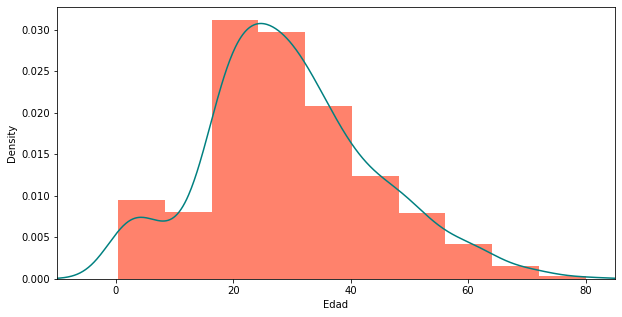

In [59]:
%matplotlib inline
plt.figure(figsize=(10,5))
plt.hist(x=train["Age"],density=True, color="tomato",stacked=True, alpha=0.8)
train["Age"].plot(kind='density', color='teal')
plt.xlim(-10,85) #ponemos los limites mas cercanos a los datos
plt.xlabel("Edad")

La edad tiende a tener una distribución normal como era de esperarse. Para evaluar la relación de la edad con la supervivencia, generamos una categoría de edad con 4 categorías:
* Entre 0 y 20 años
* Entre 20 y 40 años
* Entre 40 y 60 años
* Más de 60 años (siendo que llega hasta 80, son los rangos iguales)

In [60]:
# completamos los 263 valores nulos de la edad
train["Age"] = train["Age"].fillna(train["Age"].mean())
print("La cantidad de valores nulos de la variable Age es de: {}".format(train["Age"].isna().sum()))

La cantidad de valores nulos de la variable Age es de: 0


In [61]:
# pasamos la edad de float a int
train["Age"] = train["Age"].astype(int)
train["Age"].dtype

dtype('int64')

In [62]:
# generamos la nueva columna y le asignamos los valores
train["Age_Cat"] = train["Age"].apply(lambda x: ("Entre 0 y 20" if x <= 20 else "Entre 20 y 40" if x <= 40 else 
                                                 "Entre 40 y 60" if x <= 60 else "Más de 60" ))

In [63]:
#validamos que se haya cargado correctamente
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,Entre 20 y 40
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,Entre 20 y 40
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,Entre 20 y 40
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,Entre 20 y 40
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,Entre 20 y 40
5,6,0,3,"Moran, Mr. James",male,29,0,0,330877,8.4583,NaN,Q,Entre 20 y 40
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S,Entre 40 y 60
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,NaN,S,Entre 0 y 20
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,NaN,S,Entre 20 y 40
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,NaN,C,Entre 0 y 20


Text(0.5, 1.0, 'Relación entre edad y supervivencia')

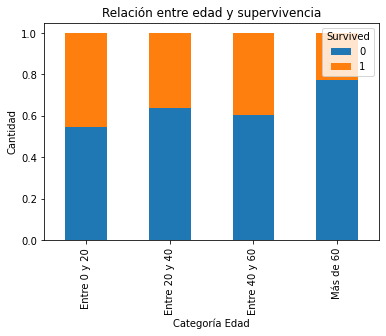

In [64]:
%matplotlib inline
table=pd.crosstab(train["Age_Cat"], train["Survived"]) # generamos la tabla
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True) # generamos los porcentajes y hacemos un stacked
plt.xlabel("Categoría Edad")
plt.ylabel("Cantidad")
plt.title("Relación entre edad y supervivencia")

Acá se ve otra relación lógica: los más jóvenes fueron quienes más sobrevivieron. Esto probablemente se acentúa en los mas niños.

In [65]:
#comprobamos la relación con los niños menores de 10 años
pd.crosstab(train["Age"]<10, train["Survived"])

Survived,0,1
Age,,
False,525,304
True,24,38


Vemos por ejemplo en esta tabla que había 62 niños menores de 10 años y 38 sobrevivieron (61%), lo cual comprueba lo dicho anteriormente

### 1.2. Sobrevivientes

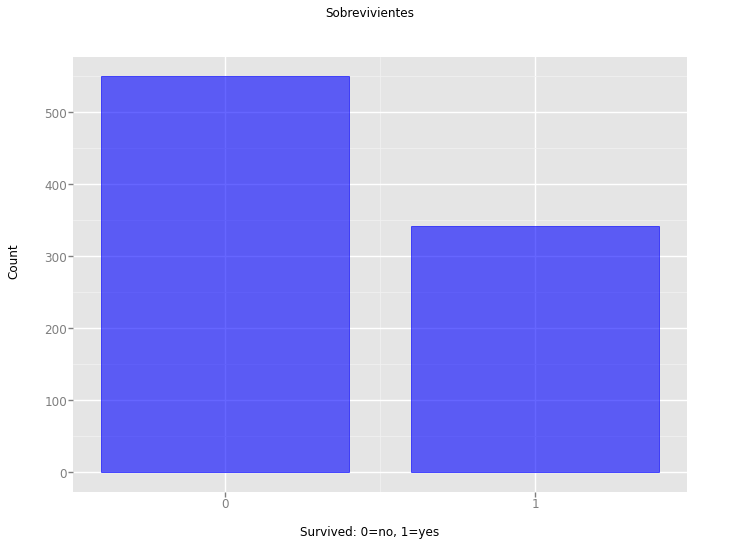

<ggplot: (8776733873803)>

In [66]:
ggplot(aes("Survived"),train) + geom_bar(fill="blue",alpha=0.6) +\
xlab("Survived: 0=no, 1=yes")+\
ylab("Count")+\
ggtitle("Sobrevivientes")

In [67]:
# tabla de recuento
pd.crosstab(train["Survived"], columns=["Count"])

col_0,Count
Survived,
0,549
1,342


In [68]:
# porcentaje de sobrevivivientes
sob= 342/(342+549)
print("El porcentaje de sobrevivientes es de: ",round(sob*100,2),"%")

El porcentaje de sobrevivientes es de:  38.38 %


In [69]:
# chequeamos nuevamente si hay valores nulos
print("La cantidad de valores nulos de la variable Age es de: {}".format(train["Survived"].isna().sum()))

La cantidad de valores nulos de la variable Age es de: 0


### 1.3. Pclass

Text(0.5, 1.0, 'Clases de pasajeros')

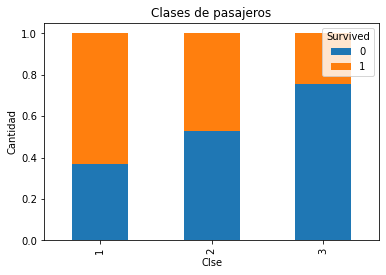

In [70]:
%matplotlib inline
table = pd.crosstab(train["Pclass"], train["Survived"])
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel("Clse")
plt.ylabel("Cantidad")
plt.title("Clases de pasajeros")

Acá se ve una tendencia clara: mientras disminuye la clase (y la tarifa pagada), disminuye el porcentaje de sobrevivientes. Esto se puede dar a diversos motivos, como la seguridad de las cabinas o simplemente la priorización de las vidas de la clase alta.

In [71]:
# chequeamos nuevamente si hay valores nulos
print("La cantidad de valores nulos de la variable Pclass es de: {}".format(train["Pclass"].isna().sum()))

La cantidad de valores nulos de la variable Pclass es de: 0


In [72]:
# dumificación de la variable 
train = train.join(pd.get_dummies(train["Pclass"], prefix="Pclass"))

In [73]:
# validamos que se haya aplicado correctamente
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Cat,Pclass_1,Pclass_2,Pclass_3
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,Entre 20 y 40,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,Entre 20 y 40,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,Entre 20 y 40,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,Entre 20 y 40,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,Entre 20 y 40,0,0,1


### 1.4. Fare

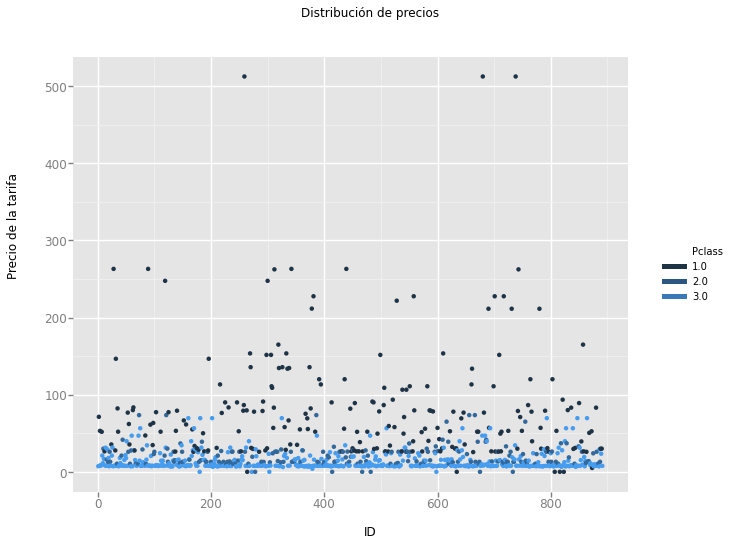

<ggplot: (8776732029437)>

In [74]:
# vemos como se distribuyen los precios de los tickets
ggplot(aes(x="PassengerId",y="Fare", color="Pclass"),train) + geom_point() +\
xlab("ID")+ylab("Precio de la tarifa")+ggtitle("Distribución de precios")

De este gráfico sacamos algunas conclusiones:

* Los precios mas bajos son los de la clase 3, lo cual es razonable siendo que esta clase es la que mas pasajeros utilizaron y se condice con los porcentajes de sobrevivientes.
* Hay 3 valores outliers claros por encima de los USD 500

Considerando esto, se eliminarán estos tres outliers para no sesgar demasiado los datos.

In [75]:
#eliminación de outliers
train = train.drop(train[train['Fare']>500].index) #generamos la columna dejando afuera los valores mayores a 500

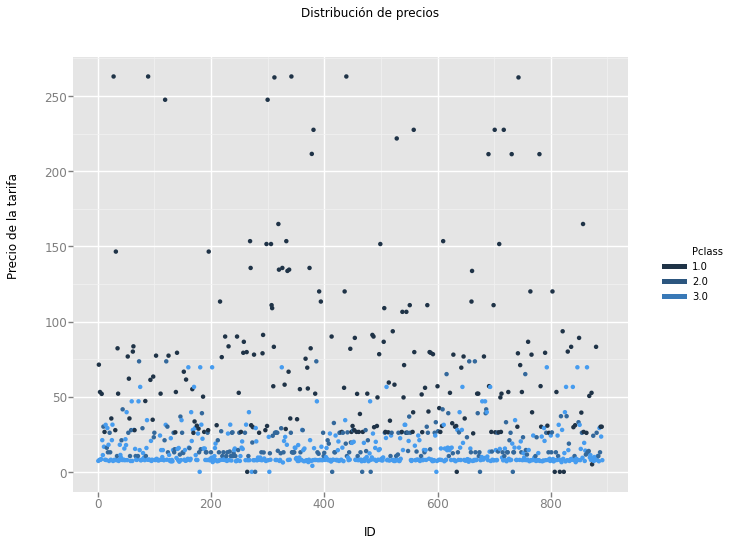

<ggplot: (8776734062571)>

In [76]:
# repetimos el gráfico. Vemos que ahora hay no están los valores superiores a 500. 
# también se podrían eliminar valores con otro filtro en caso de ser necesario
ggplot(aes(x="PassengerId",y="Fare", color="Pclass"),train) + geom_point() +\
xlab("ID")+ylab("Precio de la tarifa")+ggtitle("Distribución de precios")

### 1.5. Sex

Text(0.5, 1.0, 'Distribución por Sexo')

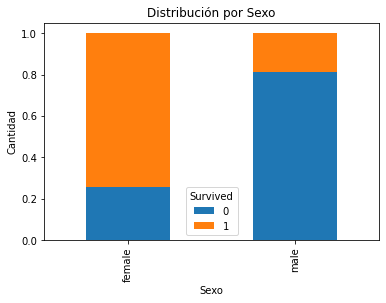

In [77]:
#vemos la variable sexo con etiquetas de sobreviviente
table = pd.crosstab(train["Sex"], train["Survived"])
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel("Sexo")
plt.ylabel("Cantidad")
plt.title("Distribución por Sexo")

In [78]:
table.div(table.sum(1).astype(float), axis=0)

Survived,0,1
Sex,,
female,0.258786,0.741214
male,0.813913,0.186087


Vemos que el sexo influye mucho en la supervivencia. El porcentaje de hombres sobrevivientes es apenas del 18% y el de las mujeres el 74%. Esto puede darse debido a que probablemente las mujeres fueron priorizadas a la hora de salvarse

In [79]:
# dumificación de la variable 
train = train.join(pd.get_dummies(train["Sex"], prefix="Sex"))
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Cat,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,Entre 20 y 40,0,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,Entre 20 y 40,1,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,Entre 20 y 40,0,0,1,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,Entre 20 y 40,1,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,Entre 20 y 40,0,0,1,0,1


### 1.6. Embarked

Text(0.5, 1.0, 'Puerta de embarque')

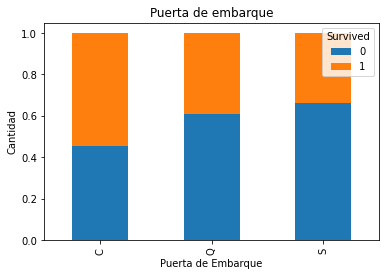

In [80]:
#vemos la variable embarked con etiquetas de sobreviviente
table = pd.crosstab(train["Embarked"], train["Survived"])
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel("Puerta de Embarque")
plt.ylabel("Cantidad")
plt.title("Puerta de embarque")

Vemos que los que más sobrevivieron fueron los de puerta de embarque C, esto probablemente está relacionado a la tarifa pagada y, por ende, la clase.

Text(0.5, 1.0, 'Puerta de embarque según clase')

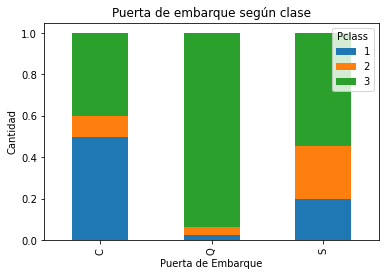

In [81]:
# comprobamos la clase según la puerta de embarque
table = pd.crosstab(train["Embarked"], train["Pclass"])
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel("Puerta de Embarque")
plt.ylabel("Cantidad")
plt.title("Puerta de embarque según clase")

Vemos que en el caso de la puerta C  y S los porcentajes de pasajeros de clase 1 con sobrevivientes son muy similares, por lo cual puede haber una relación en estas dos categorias. Sin embargo, esta relación no se vislumbra en la puerta Q

In [82]:
# dummificamos la variable y chequeamos la implementación
train = train.join(pd.get_dummies(train["Embarked"],prefix="Emb"))
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Age_Cat,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Emb_C,Emb_Q,Emb_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,...,S,Entre 20 y 40,0,0,1,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,...,C,Entre 20 y 40,1,0,0,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,...,S,Entre 20 y 40,0,0,1,1,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,...,S,Entre 20 y 40,1,0,0,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,...,S,Entre 20 y 40,0,0,1,0,1,0,0,1


### 1.7. SibSp + Parch
Estas dos variables hacen alusión a viajar en familia, por lo cual se las va a unificar en una sola categoría para simplificar y evitar la colinealidad. La columna nueva será categórica y dirá si viaja solo o acompañado

In [83]:
#nueva columna
train["Family"] = np.where((train["SibSp"]+train["Parch"])>0, 1, 0) #0 si viaja solo y 1 si viaja acompañado
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Age_Cat,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Emb_C,Emb_Q,Emb_S,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,...,Entre 20 y 40,0,0,1,0,1,0,0,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,...,Entre 20 y 40,1,0,0,1,0,1,0,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,...,Entre 20 y 40,0,0,1,1,0,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,...,Entre 20 y 40,1,0,0,1,0,0,0,1,1
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,...,Entre 20 y 40,0,0,1,0,1,0,0,1,0


In [84]:
#chequeamos nuevamente la integridad de las columnas
getMetadata(train)

,Tipo,Elementos,Nulos,Nulos %,Valores unicos
PassengerId,int64,888,0,0.00,888
Survived,int64,888,0,0.00,2
Pclass,int64,888,0,0.00,3
Name,object,888,0,0.00,888
Sex,object,888,0,0.00,2
Age,int64,888,0,0.00,71
SibSp,int64,888,0,0.00,7
Parch,int64,888,0,0.00,7
Ticket,object,888,0,0.00,680
Fare,float64,888,0,0.00,247


In [85]:
#vemos que hay 2 nulos en la variable Embarked. Los reemplazamos por la mediana
train["Embarked"] = train["Embarked"].fillna(train["Embarked"].value_counts().median())

In [86]:
#chequeamos que no queden valores nulos
train["Embarked"].isna().sum()

0

La columna "Cabin" no será tenida en cuenta ya que la gran mayoría de los valores son nulos.

In [87]:
# ahora hacemos todo el mismo modelado de datos para el dataset de test

test= pd.read_csv("titanic_test.csv") #leemos el csv
test["Age"] = test["Age"].fillna(test["Age"].mean()) #rellenamos los valores nulos de Age
test["Age"] = test["Age"].astype(int) # pasamos Age a tipo int
test = test.join(pd.get_dummies(test["Pclass"], prefix="Pclass")) #dummificamos Pclass
test = test.join(pd.get_dummies(test["Sex"], prefix="Sex")) # dummificamos Sex
test = test.join(pd.get_dummies(test["Embarked"],prefix="Emb")) # dummificamos Embarked
test = test.drop(test[test['Fare']>500].index) #eliminamos outliers > 500 (si existen)
test["Family"] = np.where((test["SibSp"]+test["Parch"])>0, 1, 0) #columna Family
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Emb_C,Emb_Q,Emb_S,Family
0,892,3,"Kelly, Mr. James",male,34,0,0,330911,7.8292,NaN,Q,0,0,1,0,1,0,1,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47,1,0,363272,7.0000,NaN,S,0,0,1,1,0,0,0,1,1
2,894,2,"Myles, Mr. Thomas Francis",male,62,0,0,240276,9.6875,NaN,Q,0,1,0,0,1,0,1,0,0
3,895,3,"Wirz, Mr. Albert",male,27,0,0,315154,8.6625,NaN,S,0,0,1,0,1,0,0,1,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22,1,1,3101298,12.2875,NaN,S,0,0,1,1,0,0,0,1,1


In [88]:
#chequeamos los datos
getMetadata(test)

,Tipo,Elementos,Nulos,Nulos %,Valores unicos
PassengerId,int64,417,0,0.00,417
Pclass,int64,417,0,0.00,3
Name,object,417,0,0.00,417
Sex,object,417,0,0.00,2
Age,int64,417,0,0.00,63
SibSp,int64,417,0,0.00,7
Parch,int64,417,0,0.00,8
Ticket,object,417,0,0.00,362
Fare,float64,416,1,0.24,168
Cabin,object,90,327,78.42,75


**Vemos que este dataset no tiene la variable "Survived", por lo cual será utilizado para realizar predicciones sobre datos no etiquetados (inexistentes)**

In [89]:
# completamos el valor nulo de fare con la media de los precios
test["Fare"] = test["Fare"].fillna(test["Fare"].mean())
test["Fare"].isnull().sum() #chequeamos que no queden nulos

0

## 2. Modelo de Regresión Logística

Ya contando con los datos de train y test limpios y completos, se procede a realizar un modelo de regresión logística para predecir si un pasajero sobrevive o no en base a otras variables predictoras.

### 2.1. Implementación del modelo

Considerando las variables del dataset y el análisis realizado en el punto 1, se reduciran la cantidad de variables a fines de trabajar el modelo predictivo. Se descarta la variable "Cabin" por no tener suficientes datos y otras que no son relevantes para realizar predicciones (ID del pasajero, Ticket y Nombre)

In [90]:
# Seleccion de variables que se tendrán en cuenta tanto predictoras (X) como a predecir (Y)
X = ["Age","Fare","Pclass_1","Pclass_2","Pclass_3","Sex_female","Sex_male","Emb_C","Emb_Q","Emb_S","Family"]
Y = train["Survived"]

In [91]:
n=6 # cantidad de variables a seleccionar
lr = LogisticRegression() # generación de modelo de regresión logística
rfe = RFE(lr, n) # selección de variables
rfe = rfe.fit(train[X], Y.values.ravel()) # pasamos X e Y
z=list(zip(X,rfe.support_, rfe.ranking_)) # listado de ranking de variables
z=pd.DataFrame({
    "Variable":X,
    "Support":rfe.support_,
    "Ranking":rfe.ranking_
}) # dataframe de la selección de variables
z.sort_values(by="Ranking") # imprimimos el dataframe ordenado por ranking de mayor a menor

/Users/csecchi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=6 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/csecchi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/csecchi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATION

,Variable,Support,Ranking
2,Pclass_1,True,1
3,Pclass_2,True,1
4,Pclass_3,True,1
5,Sex_female,True,1
6,Sex_male,True,1
9,Emb_S,True,1
7,Emb_C,False,2
10,Family,False,3
8,Emb_Q,False,4
0,Age,False,5


In [92]:
X = [] # lista vacía

# generamos un bucle que complete la lista de variables seleccionadas
for var in z.values:
    if var[2] == 1:
        X.append(var[0])
X

['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Emb_S']

In [93]:
# dividimos el dataset en datos de entrenamiento y testing en proporcion 70/30
X_train, X_test, Y_train, Y_test = train_test_split(train[X],Y, test_size = 0.3 , random_state=0)

# generamos y ajustamos el modelo con los datos de entrenamiento
lr = LogisticRegression()
lr.fit(X_train,Y_train)

# generamos las predicciones con los datos de test
prob = lr.predict_proba(X_test)

In [94]:
prob

array([[0.47502999, 0.52497001],
       [0.91754956, 0.08245044],
       [0.13291522, 0.86708478],
       [0.91754956, 0.08245044],
       [0.47502999, 0.52497001],
       [0.65340658, 0.34659342],
       [0.77565786, 0.22434214],
       [0.13291522, 0.86708478],
       [0.47502999, 0.52497001],
       [0.77565786, 0.22434214],
       [0.91754956, 0.08245044],
       [0.07194446, 0.92805554],
       [0.31394604, 0.68605396],
       [0.77565786, 0.22434214],
       [0.31394604, 0.68605396],
       [0.91754956, 0.08245044],
       [0.48807108, 0.51192892],
       [0.47502999, 0.52497001],
       [0.84912277, 0.15087723],
       [0.13291522, 0.86708478],
       [0.77565786, 0.22434214],
       [0.13291522, 0.86708478],
       [0.65340658, 0.34659342],
       [0.77565786, 0.22434214],
       [0.07194446, 0.92805554],
       [0.84912277, 0.15087723],
       [0.48807108, 0.51192892],
       [0.65340658, 0.34659342],
       [0.65340658, 0.34659342],
       [0.65340658, 0.34659342],
       [0.

Este array tiene a la izquierda las probabilidades de 0 y a la derecha las de 1

Antes de generar las predicciones del valor 0/1, chequeamos el porcentaje de sobrevivientes para tener un parametro para el umbral

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7e2470cd0>],
      dtype=object)

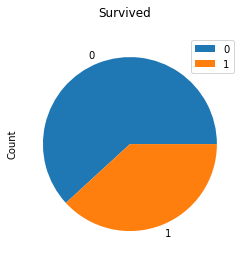

In [95]:
pd.crosstab(train["Survived"],columns="Count").plot(kind="pie", subplots=True,title ="Survived")

In [96]:
# vemos que el 38% de los pasajeros sobrevivieron
sum(train["Survived"]==1)/len(train["Survived"])

0.38175675675675674

In [97]:
#generamos las predicciones (sobrevive o no)
prob = prob[:,1] # nos quedamos con el array de probabilidades de 1 (sobrevive)
prob_df = pd.DataFrame(prob) # lo pasamos a dataframe
threshold = 0.4 #umbral apenas superior al % de sobrevivientes
prob_df["prediccion"] = np.where(prob_df[0]>threshold, 1, 0) # prediccion 0 o 1 segun umbral
prob_df["actual"] = list(Y_test) #columna de valores Y reales
prob_df.head()

,0,prediccion,actual
0,0.524970,1,0
1,0.082450,0,0
2,0.867085,1,1
3,0.082450,0,0
4,0.524970,1,1


In [98]:
# tabla de resultados
pd.crosstab(prob_df.prediccion, columns="count")

col_0,count
prediccion,
0,152
1,115


In [99]:
# matriz de confusión
confusion_matrix = pd.crosstab(prob_df.prediccion, prob_df.actual)
confusion_matrix

actual,0,1
prediccion,,
0,126,26
1,34,81


In [100]:
# resultados
accuracy = metrics.accuracy_score(Y_test, prob_df["prediccion"]) #precision
espc_1, sensit, _ = metrics.roc_curve(Y_test, prob) #sensibilidad y especificidad
auc = metrics.auc(espc_1, sensit) #area debajo de la curva ROC

print("Umbral: {}".format(threshold))
print("Precisión: {}".format(accuracy))
print("Área ROC: {}".format(auc))

Umbral: 0.4
Precisión: 0.7752808988764045
Área ROC: 0.8332359813084111


In [102]:
#generamos un df con la 1-especificidad y la sensibilidad
df = pd.DataFrame({
    "esp":espc_1,
    "sens":sensit
})

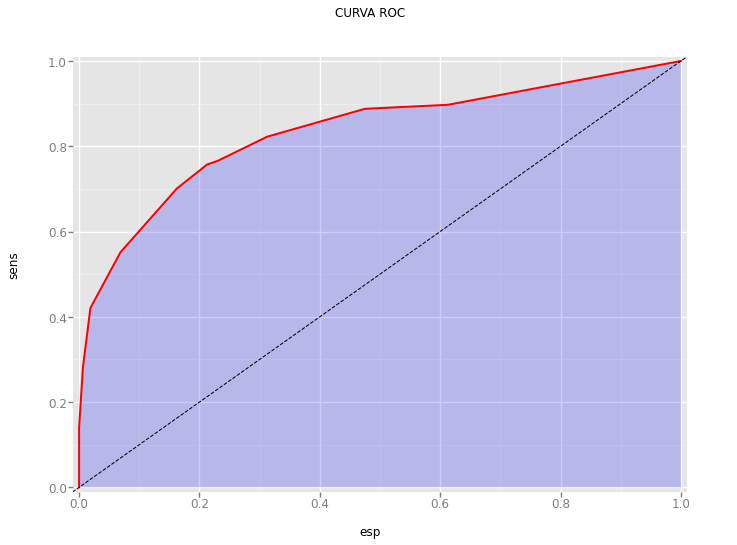

<ggplot: (8776736814839)>

In [115]:
ggplot(df, aes(x="esp", y="sens")) + geom_line(color="red", size=2) +\
geom_abline(linetype="dashed")+xlim(-0.01,1.01)+ylim(-0.01,1.01)+\
geom_area(alpha=0.2, fill="blue")+\
ggtitle("CURVA ROC")+ano

In [51]:
#probamos con otro umbral
threshold = 0.6 #umbral apenas superior al % de sobrevivientes
prob_df["prediccion"] = np.where(prob_df[0]>threshold, 1, 0) # prediccion 0 o 1 segun umbral
prob_df["actual"] = list(Y_test) #columna de valores Y reales
prob_df.head()

# resultados
accuracy = metrics.accuracy_score(Y_test, prob_df["prediccion"]) #precision
espc_1, sensit, _ = metrics.roc_curve(Y_test, prob) #sensibilidad y especificidad
auc = metrics.auc(espc_1, sensit) #area debajo de la curva ROC

print("Umbral: {}".format(threshold))
print("Precisión: {}".format(accuracy))
print("Área ROC: {}".format(auc))

Umbral: 0.6
Precisión: 0.7790262172284644
Área ROC: 0.8332359813084111


Vemos que aumentando el umbral no mejoran los indicadores, por lo cual nos quedamos con el umbral de 40%

### 2.2. Validación cruzada

In [116]:
# importación de librería
from sklearn.model_selection import cross_val_score

In [118]:
# definimos las puntuaciones. Se pasa X e Y completo de todo el dataset para que hava la validación cruzada.
# scoring="accuracy" es para que mida la eficacia y cv=10 es el valor K de cuantas divisiones.
scores = cross_val_score(LogisticRegression(), train[X], Y, scoring="accuracy", cv=10)

In [119]:
#vemos los resultados de las 10 validaciones
scores

array([0.82022472, 0.75280899, 0.76404494, 0.82022472, 0.79775281,
       0.7752809 , 0.76404494, 0.75280899, 0.81818182, 0.76136364])

In [120]:
# vemos la media
scores.mean()

0.782673646578141

**La precisión con validación cruzada es casi igual que al modelo dividido en train-test, por lo cual se puede afirmar que el modelo anterior es bueno.**

## 3. Predicciones sobre nuevos datos

Luego de haber generado el modelo, se realizan las predicciones sobre el dataset denominado "Train" que no tiene la columna de resultados "Survived".

In [135]:
prob1=lr.predict_proba(test[X])
prob_test = prob1[:,1] # nos quedamos con el array de probabilidades de 1 (sobrevive)
prob_test = pd.DataFrame(prob_test) # lo pasamos a dataframe
threshold = 0.4 #umbral apenas superior al % de sobrevivientes
prob_test["ID"] = test["PassengerId"] #columna de valores Y reales
prob_test["prediccion"] = np.where(prob_test[0]>threshold, 1, 0) # prediccion 0 o 1 segun umbral
prob_test = prob_test.drop([0],axis=1)
prob_test.head(10)

,ID,prediccion
0,892.0,0
1,893.0,1
2,894.0,0
3,895.0,0
4,896.0,1
5,897.0,0
6,898.0,1
7,899.0,0
8,900.0,1
9,901.0,0


In [136]:
# añadimos la columna de predicción al dataset de test
test["Predicción"] = prob_test["prediccion"]
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Emb_C,Emb_Q,Emb_S,Family,Predicción
0,892,3,"Kelly, Mr. James",male,34,0,0,330911,7.8292,NaN,...,0,0,1,0,1,0,1,0,0,0.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47,1,0,363272,7.0000,NaN,...,0,0,1,1,0,0,0,1,1,1.0
2,894,2,"Myles, Mr. Thomas Francis",male,62,0,0,240276,9.6875,NaN,...,0,1,0,0,1,0,1,0,0,0.0
3,895,3,"Wirz, Mr. Albert",male,27,0,0,315154,8.6625,NaN,...,0,0,1,0,1,0,0,1,0,0.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22,1,1,3101298,12.2875,NaN,...,0,0,1,1,0,0,0,1,1,1.0
